In [1]:
import configs as c

from timeit import default_timer as timer

from datetime import timedelta
from datetime import datetime

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from tqdm import tqdm

In [2]:
with open('sine12.pickle', 'wb') as handle:
    pickle.dump(np.sin(list(range(18,85)))+12, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
from model import microsim, counterfactual
import transition_matrix as tm
import model_functions as mf
import common_functions as use

# Transition probabilities

In [4]:
with open('../../3. calibration/src/var23_maintainS.pickle', 'rb') as handle:
    tp = pickle.load(handle)
tmx36 = tm.set_transition_matrix(tp)

with open('../../3. calibration/src/var20_maintainS.pickle', 'rb') as handle:
    tp = pickle.load(handle)
tmx60 = tm.set_transition_matrix(tp)

with open('../../3. calibration/src/var15_maintainS.pickle', 'rb') as handle:
    tp = pickle.load(handle)
tmx120 = tm.set_transition_matrix(tp)

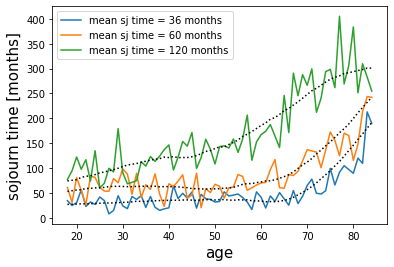

In [5]:
sj36 = np.array(mf.sojourn_time(tmx36))
sj60 = np.array(mf.sojourn_time(tmx60))
sj120 = np.array(mf.sojourn_time(tmx120))

plt.plot(c.age_range, sj36)
plt.plot(c.age_range, sj60)
plt.plot(c.age_range, sj120)

yhat36 = use.savitzky_golay(sj36, 51, 3)
yhat60 = use.savitzky_golay(sj60, 51, 3)
yhat120 = use.savitzky_golay(sj120, 51, 3)

plt.plot(c.age_range, yhat36, 'k:')
plt.plot(c.age_range, yhat60, 'k:')
plt.plot(c.age_range, yhat120, 'k:')

plt.xlabel('age', fontsize = 15)
plt.ylabel('sojourn time [months]', fontsize = 15)
plt.legend(['mean sj time = 36 months', 'mean sj time = 60 months', 'mean sj time = 120 months'])
plt.show()

35.777880902305334
62.01139184031257
120.45902703229963
389.508923535976
839.960263485509
1782.8938500755064


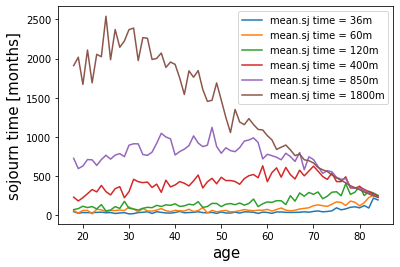

In [15]:
for i in [23, 20, 15, 10, 5, 0]:
    with open('../../3. calibration/src/' + 'var' + str(i)+'.pickle', 'rb') as handle:
        tp = pickle.load(handle)
    tmx = tm.set_transition_matrix(tp)
    plt.plot(c.age_range,mf.sojourn_time(tmx))
    print(np.mean(mf.sojourn_time(tmx)[0:42]))
plt.xlabel('age', fontsize = 15)
plt.ylabel('sojourn time [months]', fontsize = 15)
plt.legend(['mean.sj time = 36m', 'mean.sj time = 60m', 'mean.sj time = 120m', 'mean.sj time = 400m', 'mean.sj time = 850m', 'mean.sj time = 1800m'])
plt.show()

# Run model

In [7]:
from model import microsim, counterfactual
import transition_matrix as tm
import model_functions as mf

In [8]:
m0 = microsim(tmx36, 100)
states_total_df, cases, ind_state = m0.simulate_population()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 43.94it/s]


In [9]:
folder = '100demo/sj36'
states_total_df.to_csv(folder + '/states_total.csv', index = None)
cases.to_csv(folder + '/cases.csv', index = None)

In [10]:
with open(folder+'/ind_state.pickle', 'wb') as handle:
    pickle.dump(ind_state, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Counterfactual analysis

In [11]:
folder36 = '100demo/sj36'
ind_state36 = pd.read_pickle(folder36+'/ind_state.pickle')

In [12]:
test_months = [3, 6, 12, 24, 48, 60, 72, 84, 96, 108, 120]
def run_cf(ind_state, tmx, test_months):
    model = counterfactual(ind_state, tmx)
    cohort = model.cohort(included_state = ['DT1','DT2','DT3','DT4'], diedBy = ['PCMORT'])

    res = {}
    iterN = 10
    for it in tqdm(range(iterN)):
        cf_before, cf_after = {}, {}
        for i in test_months:
            cf_before[i], cf_after[i] = model.run_counterfactual_interventionBymonths(cohort, i, 'PCMORT')
        res[it] = [cf_before, cf_after]
    return res, cohort

In [13]:
res36, cohort36 = run_cf(ind_state36, tmx36, test_months)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 16.77it/s]


In [14]:
with open(folder36+'/res36.pickle', 'wb') as handle:
    pickle.dump(res36, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(folder36+'/cohort36.pickle', 'wb') as handle:
    pickle.dump(cohort36, handle, protocol=pickle.HIGHEST_PROTOCOL)